### Create a Search Routine

Now that we have turbo_seti installed and the data downloaded, we can start a Doppler drift search.
First we want to create a search object using turbo_seti.find_doppler.find_doppler.FindDoppler()

Note that this tutorial exposes a lot of internal details about `find_event_pipeline` and `plot_event_pipeline` that the first tutorial did not.

In [1]:
import os
import time
from pathlib import Path
from turbo_seti.find_doppler.find_doppler import FindDoppler

DATADIR = str(Path.home()) + "/turbo_seti_data/"

In [2]:
# Get rid of any pre-existing output files from a prior run.
for x_file in sorted(os.listdir(DATADIR)):
    x_type = x_file.split('.')[-1]
    if x_type != 'h5':
        os.remove(DATADIR + x_file)

# Get ready for search by instantiating the doppler object.
doppler = FindDoppler(DATADIR + 'single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5',
                      max_drift = 4,
                      snr = 10,       
                      out_dir = DATADIR # This is where the turboSETI output files will be stored.
                     )
print("\ntutorial_2: FindDoppler object was instantiated.")


turbo_seti version 2.1.13
blimpy version 2.0.28
h5py version 3.4.0


tutorial_2: FindDoppler object was instantiated.


Now we run the search routine on the spectra contained in this single HDF5 file:

In [3]:
t1 = time.time()
doppler.search()
print("\ntutorial_2: Search complete, et = {:.1f} seconds.".format(time.time() - t1))

HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40378167 deg>, 'src_raj': <Angle 17.21124472 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.92634259259, 'za_start': 0.0}

Starting ET search with parameters: datafile=/home/elkins/turbo_seti_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, max_drift=4, min_drift=1e-05, snr=10, out_dir=/home/elkins/turbo_seti_data/, coarse_chans=None, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0.0, 'pulsar_snr': 0.0, 'pulsar_stats': array([0., 0., 0., 0., 0., 0.]), 'RFI_level': 0.0, 'Mean_SEFD': 0.0, 'psrflux_

You will find that the search process can take several minutes, potentially more than 1 hour.  This is especially true when looking at multiple files that are Gigabytes in size. If you are doing your work on the BL servers or any other server system where you will be kicked out after an amount of time, I reccomend using either [tmux](https://github.com/tmux/tmux/wiki) or [screen](https://linuxize.com/post/how-to-use-linux-screen/). 


## Making a Pandas Dataframe
We can convert the `.dat` file produced in the previous search into a [Pandas](https://pandas.pydata.org/) dataframe so it is easier to read:

In [4]:
from turbo_seti.find_event.find_event import read_dat

df = read_dat(DATADIR + 'single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat')
df

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,RA,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range
0,1,-0.363527,22.329107,8419.565390,651879,8419.567024,8419.563761,0,23112,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,17h12m40.481s,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,,,,
1,2,-0.353960,192.895111,8419.542731,659989,8419.544365,8419.541102,0,23112,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,17h12m40.481s,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,,,,
2,3,-0.363527,22.572433,8419.520396,667983,8419.522030,8419.518767,0,23112,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,17h12m40.481s,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,,,,


## Finding Events
Now let's run the executable `turboSETI` on all of the HDF5 files from the same observation so we can find interesting events (a hit that occurs across multiple files) via the [ON/OFF method](https://github.com/UCBerkeleySETI/breakthrough/blob/master/GBT/README.md).

Normally it takes a chunk of time to run the algorithm on all of the files, so here is a little script that keeps `turboSETI` running in the background if executed in a tmux session:

In [5]:
# %load example_script.py
import glob

# glob will create a list of specific files in a directory. In this case, any file ending in .h5.
h5list = sorted(glob.glob(DATADIR + '*.h5'))

# Get rid of any pre-existing output files from a prior run.
for x_file in sorted(os.listdir(DATADIR)):
    x_type = x_file.split('.')[-1]
    if x_type != 'h5':
        os.remove(DATADIR + x_file)

# Iterate over the 6 HDF5 files
print("tutorial_2: Please wait for the \"End\" message,\n")
for file in h5list:
    # Execute turboSETI in the terminal
    console = 'turboSETI ' + file + ' -M 4 -s 10 -o ' + DATADIR
    os.system(console)
print("\ntutorial_2: All HDF5 files have been successfully processed.")
print("tutorial_2: End.")


tutorial_2: Please wait for the "End" message,


turbo_seti version 2.1.13
blimpy version 2.0.28
h5py version 3.4.0

HDF5 header info: {'DIMENSION_LABELS': array(['time', 'feed_id', 'frequency'], dtype=object), 'az_start': 0.0, 'data_type': 1, 'fch1': 8421.38671875, 'foff': -2.7939677238464355e-06, 'machine_id': 20, 'nbits': 32, 'nchans': 1048576, 'nifs': 1, 'source_name': 'VOYAGER-1', 'src_dej': <Angle 12.40378167 deg>, 'src_raj': <Angle 17.21124472 hourangle>, 'telescope_id': 6, 'tsamp': 18.253611007999982, 'tstart': 59046.92634259259, 'za_start': 0.0}

Starting ET search with parameters: datafile=/home/elkins/turbo_seti_data/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, max_drift=4.0, min_drift=1e-05, snr=10.0, out_dir=/home/elkins/turbo_seti_data/, coarse_chans=, flagging=False, n_coarse_chan=1, kernels=None, gpu_id=0, gpu_backend=False, blank_dc=True, precision=1, append_output=False, log_level_int=20, obs_info={'pulsar': 0, 'pulsar_found': 0, 'pulsar_dm': 0


tutorial_2: All HDF5 files have been successfully processed.
tutorial_2: End.


Now that we have ran `turboSETI` on six observations, let's use the `find_event_pipeline` to find events that only exist in the ON observations (on-target). 

It is important to consider the value to use for the filter_threshold. Here is a docstring explaining what filter threshold is:
```
filter_threshold        Specification for how strict the hit filtering will be.
                        There are 3 different levels of filtering, specified by
                        the integers 1, 2, and 3. 
                        
                        Filter_threshold = 1 returns hits above an SNR cut, taking into account the
                        check_zero_drift parameter, but without an ON-OFF check.
                        
                        Filter_threshold = 2 returns hits that passed level 1
                        AND that are in at least one ON but no OFFs. 
                        
                        Filter_threshold = 3 returns events that passed level 2
                        AND that are present in *ALL* ONs.
```

In [8]:
from turbo_seti.find_event.find_event_pipeline import find_event_pipeline

# A list of all the .dat files that turboSETI produced
dat_list = sorted(glob.glob(DATADIR + '*.dat'))

# This writes the dat files into a .lst, as required by the find_event_pipeline
with open(DATADIR + 'dat_files.lst', 'w') as f:
    for item in dat_list:
        f.write("%s\n" % item)

PATH_CSVF = 'maxdrift4_snr10_f3.csv'
find_event_pipeline(DATADIR + 'dat_files.lst',
                    filter_threshold = 3, # Using the strictest filter threshold value.
                    number_in_cadence = len(dat_list),
                    user_validation=False,
                    saving=True, # Save the CSV file of events.
                    csv_name=PATH_CSVF)



************   BEGINNING FIND_EVENT PIPELINE   **************

Assuming the first observation is an ON
find_event_pipeline INFO     find_event_pipeline: file=single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.dat, tstart=59046.92634259259, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     find_event_pipeline: file=single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.dat, tstart=59046.93002314815, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     find_event_pipeline: file=single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.dat, tstart=59046.933703703704, source_name=VOYAGER-1, fch1=8421.38671875, foff=-2.7939677238464355e-06, nchans=1048576
find_event_pipeline INFO     find_event_pipeline: file=single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.dat, tstart=59046.937372685185, source_name=VOYAGER-1, fch

,TopHitNum,DriftRate,SNR,Freq,ChanIndx,FreqStart,FreqEnd,CoarseChanNum,FullNumHitsInRange,FileID,...,DEC,DELTAT,DELTAF,max_drift_rate,obs_length,Hit_ID,status,in_n_ons,RFI_in_range,delta_t
0,1,-0.363527,22.329107,8419.565390,651879,8419.567024,8419.563761,0,23112,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_0,on_table_1,2,0,0.0
3,1,-0.401793,10.996549,8419.565152,651964,8419.566787,8419.563523,0,689,single_coarse_guppi_59046_80672_DIAG_VOYAGER-1...,...,12d24m13.656s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_0,on_table_2,,0,636.0
6,1,-0.411359,18.529829,8419.564890,652058,8419.566524,8419.563261,0,4819,single_coarse_guppi_59046_81310_DIAG_VOYAGER-1...,...,12d24m13.608s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_0,on_table_3,,0,1274.0
1,2,-0.353960,192.895111,8419.542731,659989,8419.544365,8419.541102,0,23112,single_coarse_guppi_59046_80036_DIAG_VOYAGER-1...,...,12d24m13.614s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_1,on_table_1,2,0,0.0
4,2,-0.382660,82.802612,8419.542493,660074,8419.544128,8419.540864,0,689,single_coarse_guppi_59046_80672_DIAG_VOYAGER-1...,...,12d24m13.656s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_1,on_table_2,,0,636.0
7,2,-0.430492,145.126450,8419.542236,660166,8419.543871,8419.540607,0,4819,single_coarse_guppi_59046_81310_DIAG_VOYAGER-1...,...,12d24m13.608s,18.253611,-2.793968,4.000000,292.057776,VOYAGER-1_1,on_table_3,,0,1274.0


## Plotting events
Now that we have some events, let's generate plots for them.  The `plot_event_pipeline` will output the plots as PNG files.

In [9]:
from turbo_seti.find_event.plot_event_pipeline import plot_event_pipeline

# We need to create a .lst of the .h5 files, so lets go ahead and do that:
filelist = sorted(glob.glob(DATADIR + '*.h5'))

# Write file locations to a .lst
with open(DATADIR + 'h5list.lst', 'w') as f:
    for item in filelist:
        f.write("{}\n".format(item))

# and finally we plot
print("tutorial_2: Plots will be stored here: {}".format(DATADIR))
print("tutorial_2: Please wait for the \"End\" message,\n")
plot_event_pipeline(PATH_CSVF,
                    DATADIR + 'h5list.lst',
                    filter_spec=3,
                    plot_dir=DATADIR,
                    user_validation=False)
print("\ntutorial_2: End, all plots are complete.")


tutorial_2: Plots will be stored here: /home/elkins/turbo_seti_data/
tutorial_2: Please wait for the "End" message,

plot_event_pipeline: Opened file maxdrift4_snr10_f3.csv
plot_event_pipeline: file = single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5, tstart = 59046.92634259259, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80354_DIAG_VOYAGER-1_0012.rawspec.0000.h5, tstart = 59046.93002314815, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80672_DIAG_VOYAGER-1_0013.rawspec.0000.h5, tstart = 59046.933703703704, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_80989_DIAG_VOYAGER-1_0014.rawspec.0000.h5, tstart = 59046.937372685185, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_81310_DIAG_VOYAGER-1_0015.rawspec.0000.h5, tstart = 59046.941087962965, source_name = VOYAGER-1
plot_event_pipeline: file = single_coarse_guppi_59046_81628_DIAG_VOYAGER-1_0016

Great! Now we can check the waterfall plot PNG files.

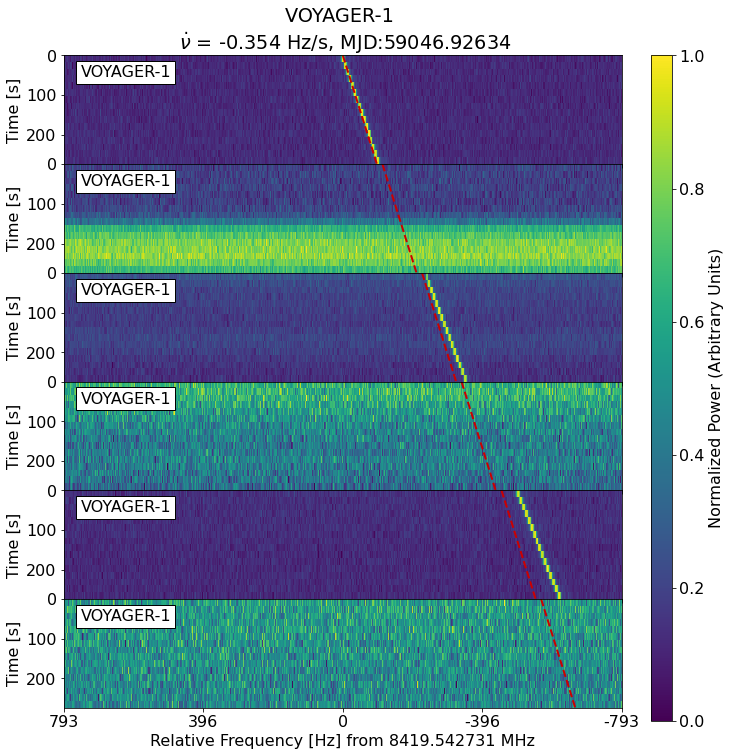

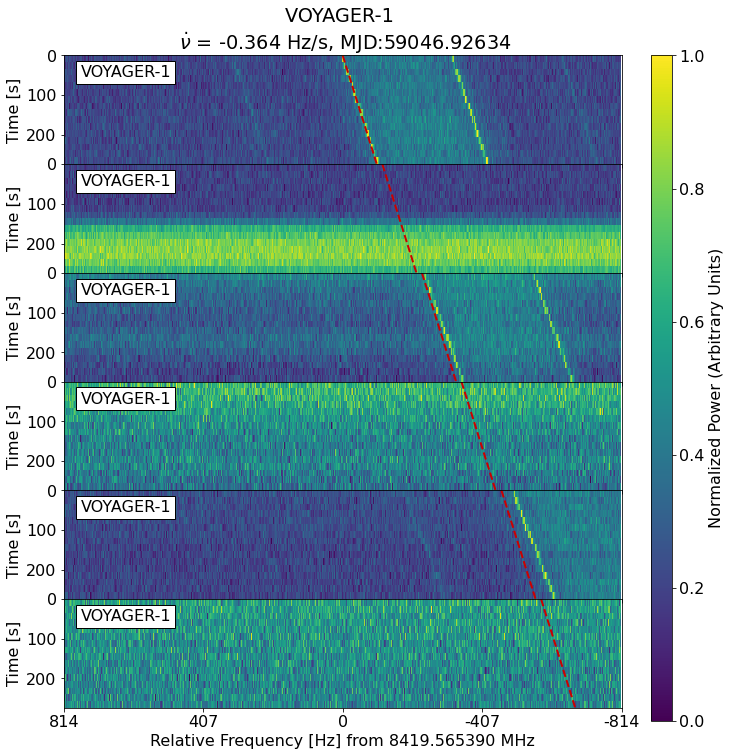

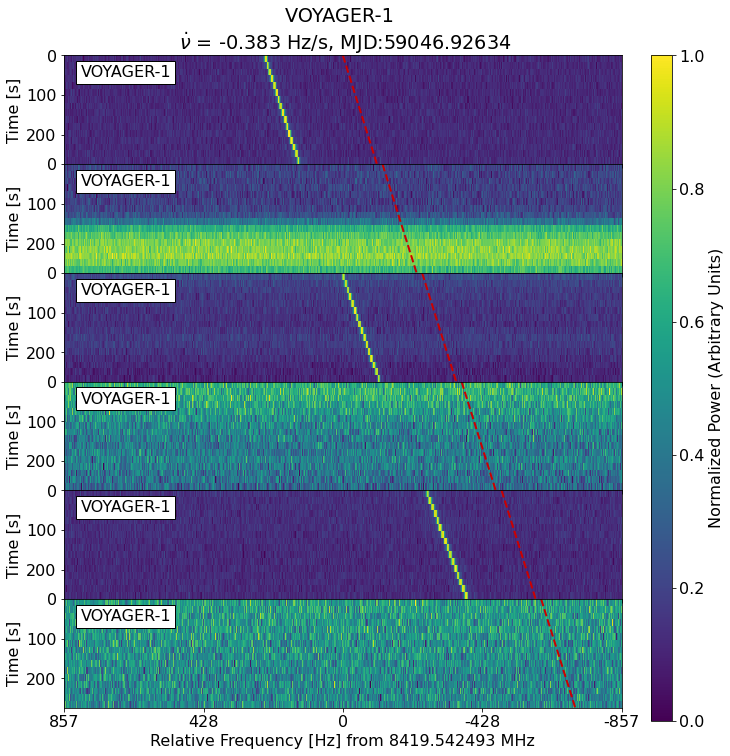

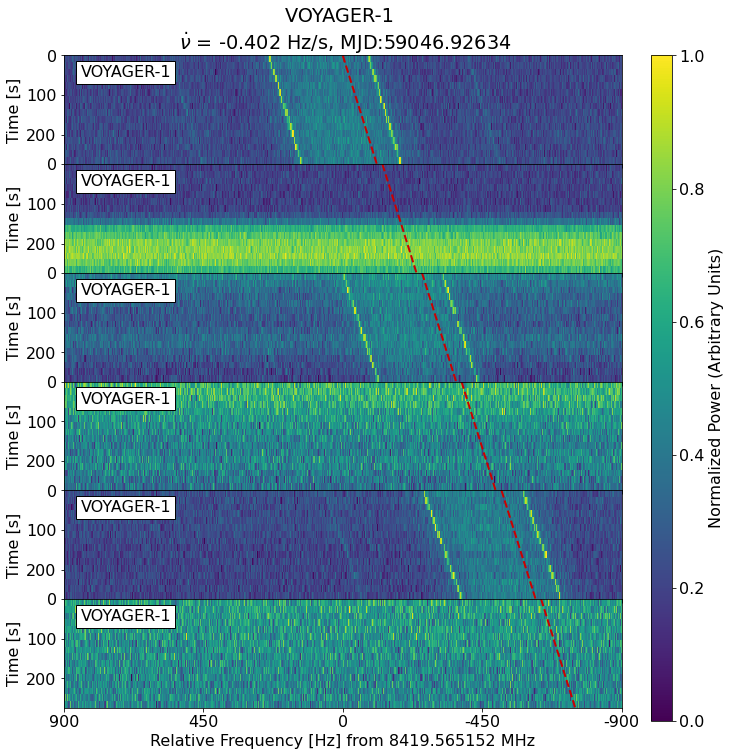

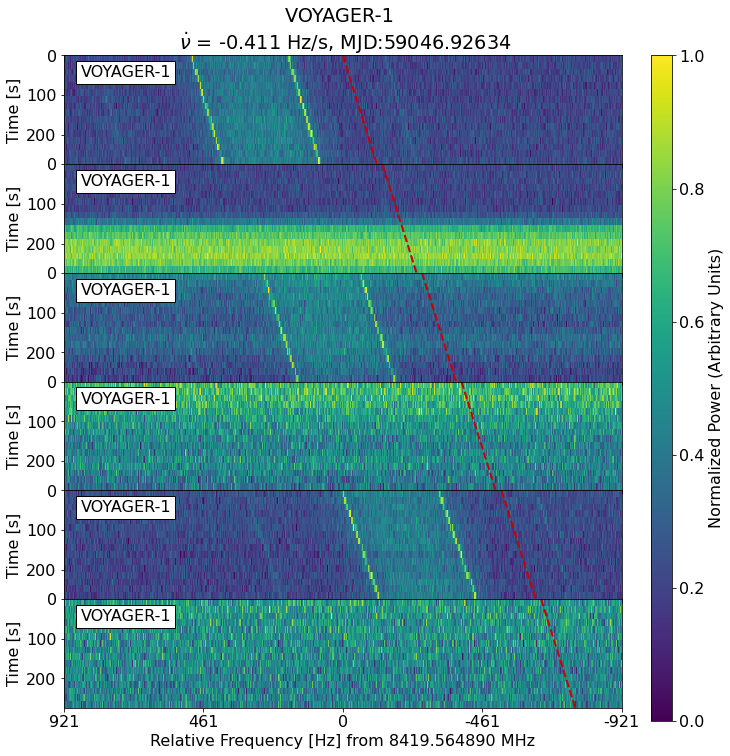

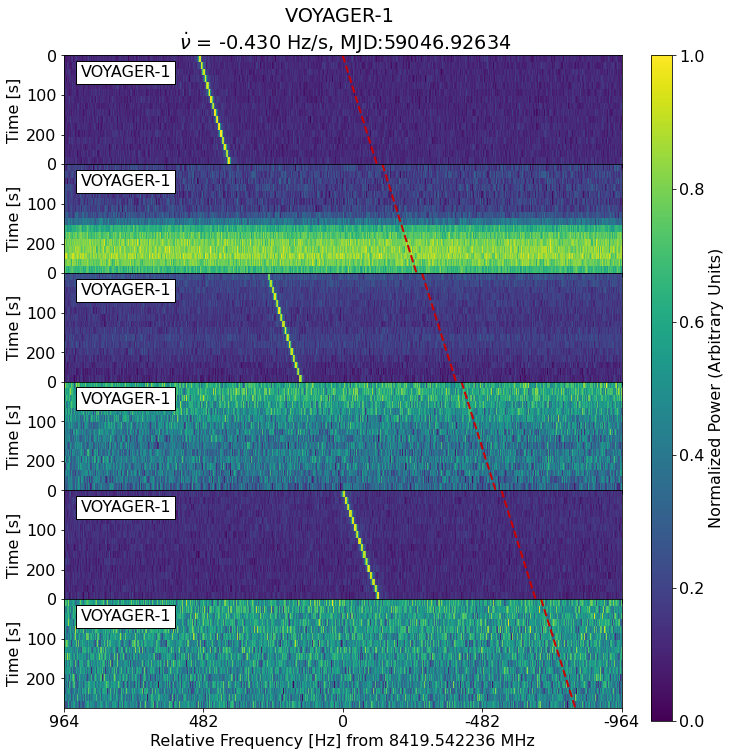

In [10]:
from IPython.display import Image, display

pnglist = sorted(glob.glob(DATADIR + '*.png'))
for pngfile in pnglist:
    display(Image(filename=pngfile))


All done!